In [47]:
import sys
import os
import logging

sys.path.insert(1, os.path.join(sys.path[0], '../../src'))
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [48]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler

In [49]:
from datasets import BoulderDataset
from visualization import plot_time_series_predictions
from evaluation import evaluate
from models import train_predict, train_predict_global

### Set Experiment Parameters

In [50]:
FORECAST_HORIZON = 30
INPUT_CHUNK_LENGTH = 30
USE_COVARIATES = False
TRAIN_DATA = 240 # 8 months
TEST_DATA = 90 # 3 months

### Load Dataset

In [51]:
series_dataset = BoulderDataset()
series = series_dataset.load(subset=None, train_length=TRAIN_DATA, test_length=TEST_DATA, na_threshold=0.1)

Found 32 time-series in dataset
Found 29 time-series of length train_length + test_length = 330
Found 9 time-series with less than 10.0% missing values
Filled missing values in 9 time-series


## Scale series Data

In [52]:
# Transform splits
series_scaler = Scaler(MinMaxScaler())
series_train = series_scaler.fit_transform(series['train'])
series_test= series_scaler.transform(series['test'])

In [53]:
predictions = {}

# Baseline

In [54]:
from darts.models.forecasting.baselines import NaiveMean
def load_baselinemodel():
    return NaiveMean()

In [55]:
predictions_baseline = []
for series_train_single, series_test_single in zip(series_train, series_test):
    model = load_baselinemodel()

    forecast = train_predict(model, 
                        series_train=series_train_single, 
                        series_test=series_test_single, 
                        horizon=FORECAST_HORIZON, 
                        retrain=True)
    
    predictions_baseline.append(forecast)
predictions_baseline = series_scaler.inverse_transform(predictions_baseline)
predictions['Baseline'] = predictions_baseline

In [56]:
evaluate(predictions['Baseline'], series['test'])

{'RMSE': 24.890076871661222,
 'MAE': 19.95345820788701,
 'MAPE': 51.283009536826384}

# Local Training

#### ARIMA

In [57]:
def load_arimamodel():
    from darts.models import ARIMA
    return ARIMA(
        p=INPUT_CHUNK_LENGTH,
        d=0,
        q=INPUT_CHUNK_LENGTH
    )

In [58]:
%%capture
predictions_arima = []
for series_train_single, series_test_single in zip(series_train, series_test):
    model = load_arimamodel()

    forecast = train_predict(model, 
                        series_train=series_train_single, 
                        series_test=series_test_single, 
                        horizon=FORECAST_HORIZON, 
                        retrain=False)
    
    predictions_arima.append(forecast)
predictions_arima = series_scaler.inverse_transform(predictions_arima)
predictions['ARIMA'] = predictions_arima

In [59]:
evaluate(predictions['ARIMA'], series['test'])

{'RMSE': 25.352886468131423,
 'MAE': 19.873577964086177,
 'MAPE': 56.249894923499525}

## Transformer

In [60]:
from darts.models import TransformerModel

def load_transformermodel():
    return TransformerModel(
        nr_epochs_val_period=1,
        nhead=8,
        num_encoder_layers=1,
        num_decoder_layers=1,
        dim_feedforward=128,
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=FORECAST_HORIZON,
        random_state=0,
        # add_encoders=past_datetime_encoder,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [61]:
predictions_transformer = []
for series_train_single, series_test_single in zip(series_train, series_test):
    model = load_transformermodel()

    forecast = train_predict(model,
                        series_train=series_train_single,
                        series_test=series_test_single,
                        horizon=FORECAST_HORIZON,
                        train_split=0.7,
                        retrain=False)
    
    predictions_transformer.append(forecast)
predictions_transformer = series_scaler.inverse_transform(predictions_transformer)
predictions['Transformer'] = predictions_transformer

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [62]:
evaluate(predictions['Transformer'], series['test'])

{'RMSE': 25.736155578483125,
 'MAE': 20.827856167284857,
 'MAPE': 49.41888338166134}

## NHITS

In [63]:
from darts.models import NHiTSModel

def load_nhitsmodel():
    return NHiTSModel(
        nr_epochs_val_period=1,
        input_chunk_length=INPUT_CHUNK_LENGTH,
        output_chunk_length=FORECAST_HORIZON,
        random_state=0,
        # add_encoders=past_datetime_encoder,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [64]:
%%capture
predictions_nhits = []
for series_train_single, series_test_single in zip(series_train, series_test):
    model = load_nhitsmodel()

    forecast = train_predict(model,
                        series_train=series_train_single,
                        series_test=series_test_single,
                        horizon=FORECAST_HORIZON,
                        train_split=0.7,
                        retrain=False)
    
    predictions_nhits.append(forecast)
predictions_nhits = series_scaler.inverse_transform(predictions_nhits)
predictions['NHiTS (Local)'] = predictions_nhits

In [65]:
evaluate(predictions['NHiTS (Local)'], series['test'])

{'RMSE': 24.806141313193997,
 'MAE': 19.925261906645463,
 'MAPE': 48.28581788629365}

# Global Training

In [66]:

nhits_model = load_nhitsmodel()
nhits_model_fit, predictions_nhits_global = train_predict_global(
                                                            model=nhits_model, 
                                                            series_train=series_train, 
                                                            series_test=series_test, 
                                                            horizon=FORECAST_HORIZON, 
                                                            train_split=0.7, 
                                                            retrain=False
                                                        )

predictions_nhits_global = series_scaler.inverse_transform(predictions_nhits_global)
predictions['NHiTS (Global)'] = predictions_nhits_global


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [67]:
evaluate(predictions['NHiTS (Global)'], series['test'])

{'RMSE': 23.66486531833431,
 'MAE': 18.94015060391738,
 'MAPE': 45.01562335434152}

# Results

## Metrics

In [68]:
print(f"{USE_COVARIATES=},{FORECAST_HORIZON=},{INPUT_CHUNK_LENGTH=},{TRAIN_DATA=},{TEST_DATA=}, {series_dataset.__class__.__name__},{len(series['train'])=},{len(series['test'])=})")
for model, model_predictions in predictions.items():
    results = evaluate(model_predictions, series['test'])
    print(f"Model:", model, results)

USE_COVARIATES=False,FORECAST_HORIZON=30,INPUT_CHUNK_LENGTH=30,TRAIN_DATA=240,TEST_DATA=90, BoulderDataset,len(series['train'])=9,len(series['test'])=9)
Model: Baseline {'RMSE': 24.890076871661222, 'MAE': 19.95345820788701, 'MAPE': 51.283009536826384}
Model: ARIMA {'RMSE': 25.352886468131423, 'MAE': 19.873577964086177, 'MAPE': 56.249894923499525}
Model: Transformer {'RMSE': 25.736155578483125, 'MAE': 20.827856167284857, 'MAPE': 49.41888338166134}
Model: NHiTS (Local) {'RMSE': 24.806141313193997, 'MAE': 19.925261906645463, 'MAPE': 48.28581788629365}
Model: NHiTS (Global) {'RMSE': 23.66486531833431, 'MAE': 18.94015060391738, 'MAPE': 45.01562335434152}


## Visualisation

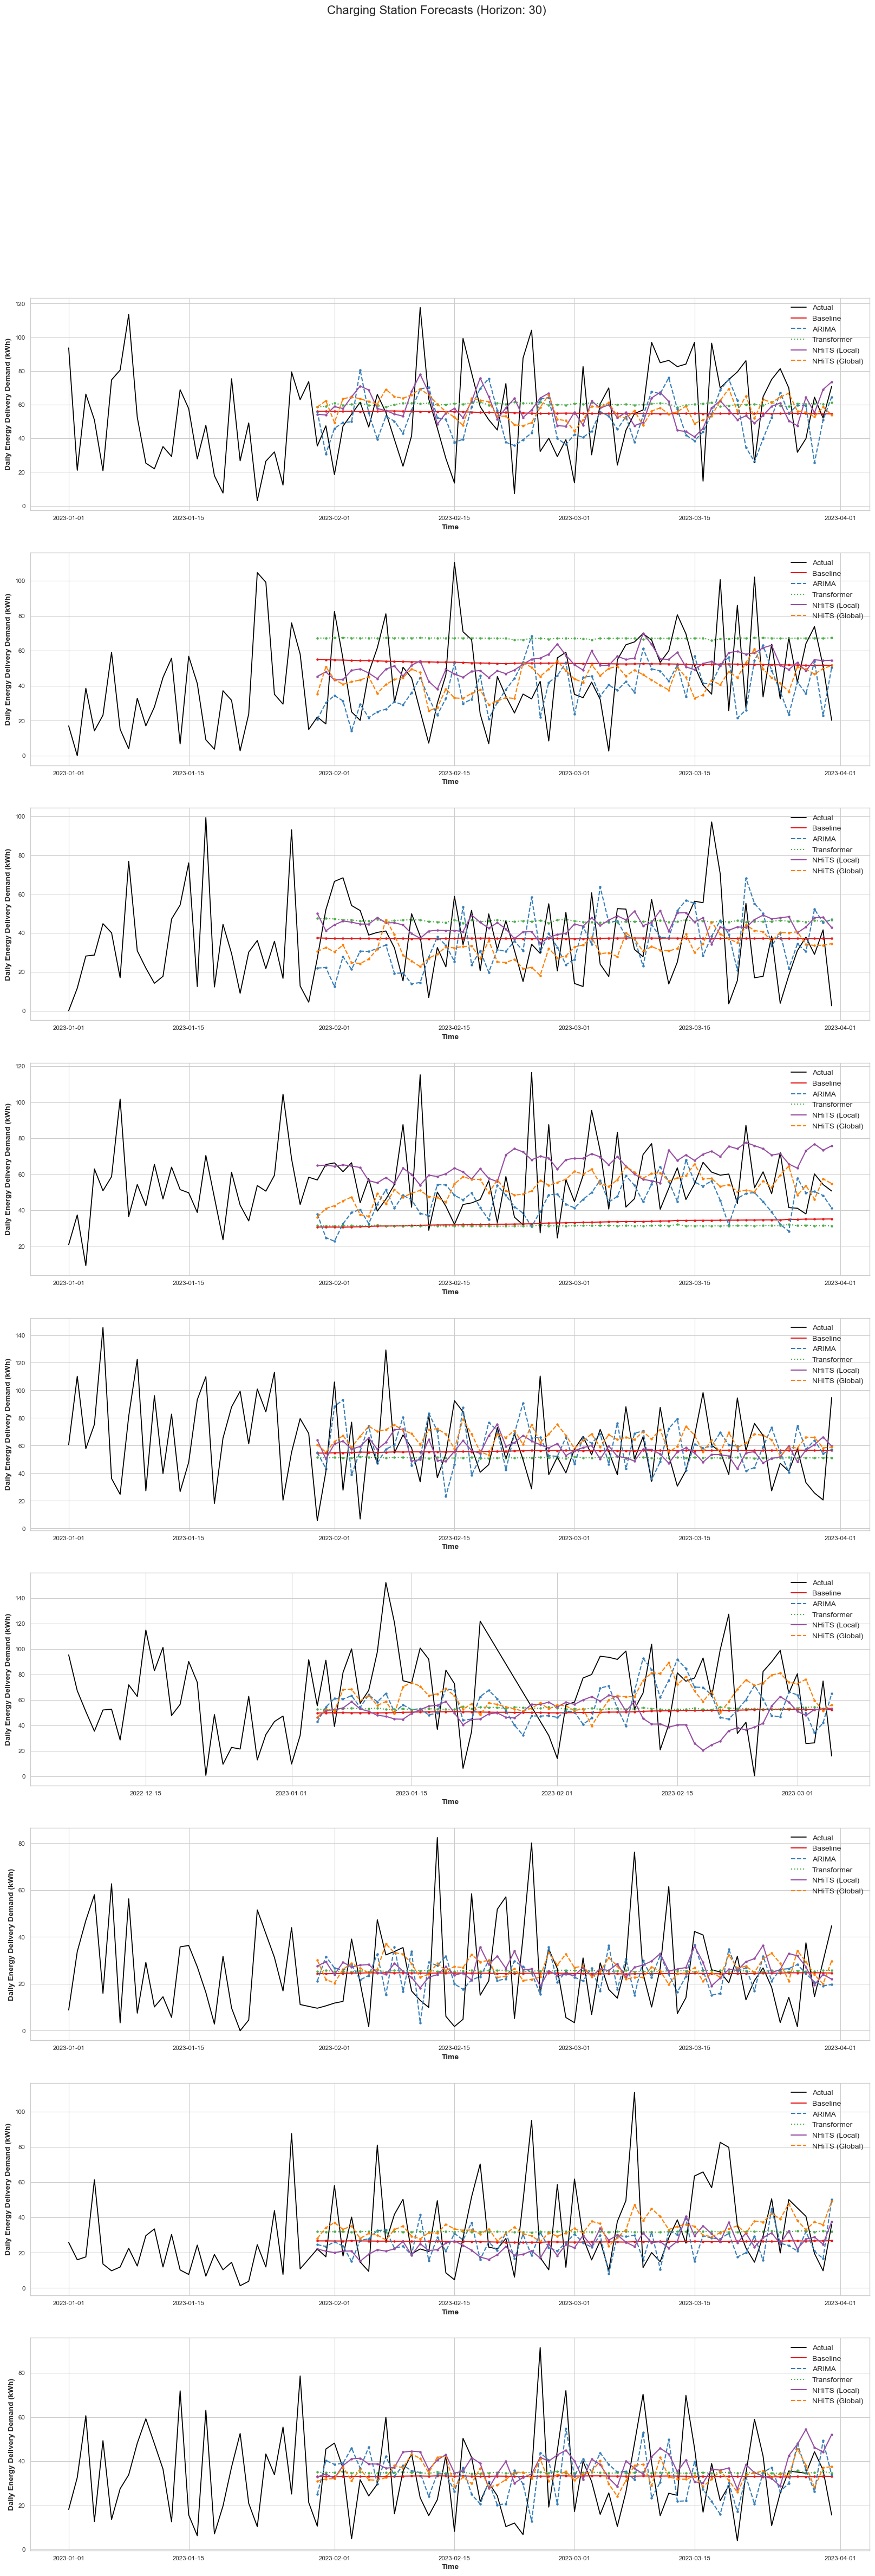

In [69]:
plot_time_series_predictions(predictions, series['test'], FORECAST_HORIZON)